In [1]:
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_context("notebook")
sns.set_style("dark")

In [4]:
use_example = False
if use_example:
    with open("example-real-data.json", "rb") as f:
        old_raw_data = json.load(f)
else:
    old_raw_data = {"data": []}
    files = os.listdir("./data/")
    for file in files:
        if file.endswith(".json"):
            with open(f"data/{file}", "r") as f:
                match_data = json.load(f)
                match_ts = file.replace(".json", "")
                if len(match_data["data"]) < 1000:
                    continue
                old_raw_data["data"] += [{**el, "match_ts": match_ts} for el in match_data["data"]]

In [5]:
len(old_raw_data["data"])

75891

## Loading raw data from analytics system

In [6]:
is_veteran_regex = r'\w+\-\w*V\w*'

In [7]:
show_outliers = False
share_x = 'all'

In [8]:
raw_data = []

for el in old_raw_data["data"]:
    # Value
    if "value" in el:
        el["value"] = float(el["value"])

    # Unique ts of match
    if "i" in el:
        el["i"] = el["i"] + "-" + el["match_ts"]
    if "t" in el:
        el["t"] = el["t"] + "-" + el["match_ts"]
    if "ips" in el:
        el["ips"] = el["ips"] + "-" + el["match_ts"]
    if "tps" in el:
        el["tps"] = el["tps"] + "-" + el["match_ts"]

    # Classes
    if "il" in el and "if" in el:
        el["i-faction-class"] = el["if"] + "-" + el["il"]
        el["i-is-veteran"] = bool(re.search(is_veteran_regex, el["i-faction-class"]))

    if "tl" in el and "tf" in el:
        el["t-faction-class"] = el["tf"] + "-" + el["tl"]
        el["t-is-veteran"] = bool(re.search(is_veteran_regex, el["t-faction-class"]))

    # Instigator coords
    if "ic" in el:
        el["ic_x"] = float(el["ic"].split(" ")[0].split("=")[1])
    if "ic" in el:
        el["ic_y"] = float(el["ic"].split(" ")[1].split("=")[1])

    # Target coords
    if "tc" in el:
        el["tc_x"] = float(el["tc"].split(" ")[0].split("=")[1])
    if "tc" in el:
        el["tc_y"] = float(el["tc"].split(" ")[1].split("=")[1])

    raw_data.append(el)

## Analyzing damage (per pawn, per class)

In [9]:
damage_df = pd.DataFrame([el for el in raw_data if el["Type"] == "Damage"])

In [10]:
# Removing friendly fire when analyzing damage
damage_df = damage_df[damage_df["if"] != damage_df["tf"]]

# Leave only damage from characters to characters
damage_df = damage_df[damage_df['i'].str.startswith("CH_")]
damage_df = damage_df[damage_df['t'].str.startswith("CH_")]

In [11]:
damage_df.head()

,value,i,t,ips,tps,il,tl,if,tf,ic,...,Type,match_ts,i-faction-class,i-is-veteran,t-faction-class,t-is-veteran,ic_x,ic_y,tc_x,tc_y
0,110.0,CH_2147295112-2023-10-01T17-44-35.162716,CH_2147294427-2023-10-01T17-44-35.162716,PS_2147297338-2023-10-01T17-44-35.162716,PS_2147302171-2023-10-01T17-44-35.162716,MelS,TacS,LSM,CSM,X=67178.180 Y=23035.740 Z=-6709.760,...,Damage,2023-10-01T17-44-35.162716,LSM-MelS,False,CSM-TacS,False,67178.180,23035.740,67356.499,22960.535
1,110.0,CH_2147295112-2023-10-01T17-44-35.162716,CH_2147294427-2023-10-01T17-44-35.162716,PS_2147297338-2023-10-01T17-44-35.162716,PS_2147302171-2023-10-01T17-44-35.162716,MelS,TacS,LSM,CSM,X=67420.020 Y=22947.930 Z=-6780.170,...,Damage,2023-10-01T17-44-35.162716,LSM-MelS,False,CSM-TacS,False,67420.020,22947.930,67480.729,22876.469
2,30.0,CH_2147294427-2023-10-01T17-44-35.162716,CH_2147295112-2023-10-01T17-44-35.162716,PS_2147302171-2023-10-01T17-44-35.162716,PS_2147297338-2023-10-01T17-44-35.162716,TacS,MelS,CSM,LSM,X=73298.780 Y=18891.453 Z=-8788.936,...,Damage,2023-10-01T17-44-35.162716,CSM-TacS,False,LSM-MelS,False,73298.780,18891.453,69182.634,20916.218
3,15.0,CH_2147294427-2023-10-01T17-44-35.162716,CH_2147295112-2023-10-01T17-44-35.162716,PS_2147302171-2023-10-01T17-44-35.162716,PS_2147297338-2023-10-01T17-44-35.162716,TacS,MelS,CSM,LSM,X=73345.809 Y=18867.209 Z=-8801.947,...,Damage,2023-10-01T17-44-35.162716,CSM-TacS,False,LSM-MelS,False,73345.809,18867.209,69700.801,20670.453
4,30.0,CH_2147294427-2023-10-01T17-44-35.162716,CH_2147295112-2023-10-01T17-44-35.162716,PS_2147302171-2023-10-01T17-44-35.162716,PS_2147297338-2023-10-01T17-44-35.162716,TacS,MelS,CSM,LSM,X=73421.529 Y=18828.155 Z=-8822.969,...,Damage,2023-10-01T17-44-35.162716,CSM-TacS,False,LSM-MelS,False,73421.529,18828.155,69840.658,20609.591


In [12]:
damage_per_pawn = damage_df.groupby(["i"]).agg(
    damage_per_life=('value', 'sum'),
    loadout=('i-faction-class', 'first'),
    is_veteran=('i-is-veteran', 'first'),
    faction=('if', 'first')
)

In [13]:
damage_per_life_for_classes = damage_per_pawn.sort_values(by='loadout').groupby("loadout").agg(
    mean_damage_per_life=('damage_per_life', 'mean'),
    std_damage_per_life=('damage_per_life', 'std')
)
damage_per_life_for_classes

,mean_damage_per_life,std_damage_per_life
loadout,,
CSM-AucV,1228.629221,711.291727
CSM-GravCannonStandard,645.997014,651.793747
CSM-HboS,676.751889,720.058086
CSM-JpaS,776.120159,783.889894
CSM-JpaVA,2377.916622,2023.356741
CSM-LcaS,420.165688,377.375290
CSM-MelS,650.089981,854.081168
CSM-MelV,1230.882149,1547.316314
CSM-PcaS,672.538165,808.640812


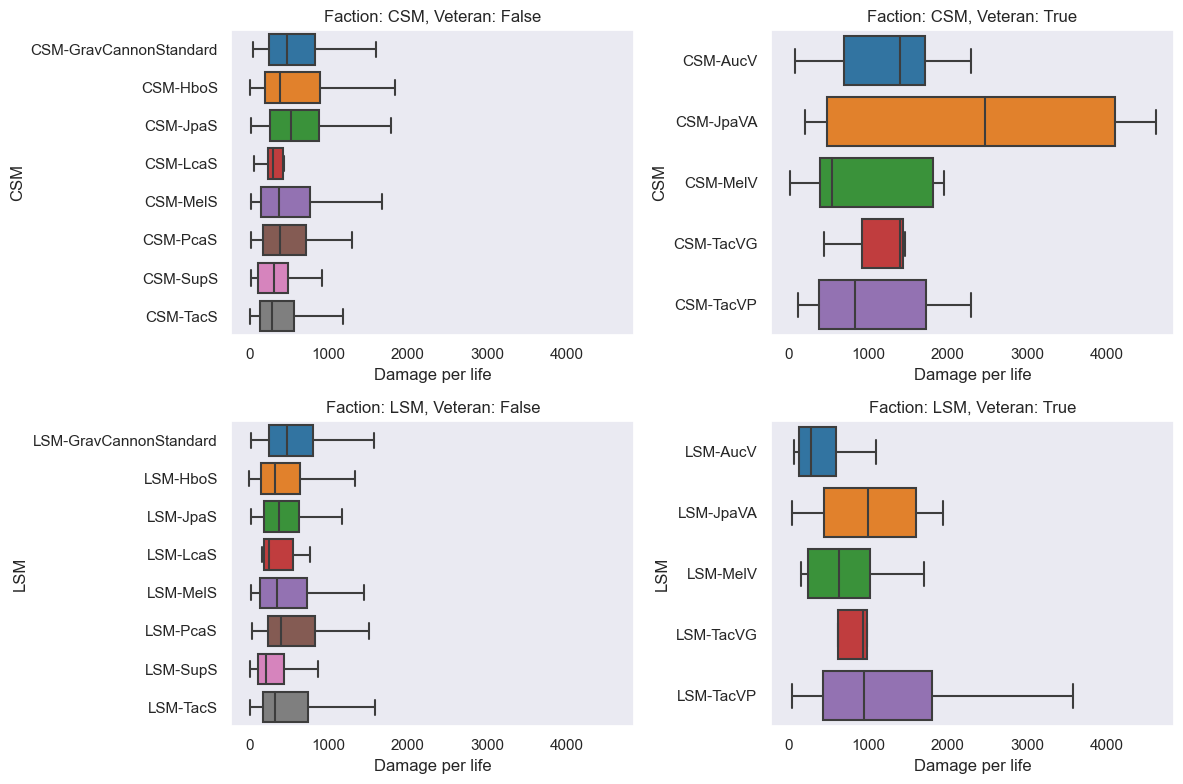

In [14]:
# Create a grid of subplots
fig, axes = plt.subplots(
    nrows=len(damage_per_pawn['faction'].unique()),
    ncols=len(damage_per_pawn['is_veteran'].unique()),
    figsize=(12, 8),
    sharex=share_x
)

# Grouping into subplots
for ((faction, veteran), subset), ax in zip(damage_per_pawn.groupby(['faction', 'is_veteran']), axes.flat):
    subset = subset.sort_values(by='loadout')  # Sort by 'loadout'
    sns.boxplot(x='damage_per_life', y='loadout', data=subset, ax=ax, orient='h', showfliers=show_outliers)

    # Set titles and axis labels
    ax.set_title(f'Faction: {faction}, Veteran: {veteran}')
    ax.set_xlabel('Damage per life')
    ax.set_ylabel(faction)

    # Set x-axis ticks for each subplot
    ax.tick_params(axis='x', labelbottom=True)

# Adjust layout
plt.tight_layout()
plt.show()

## Analyzing XP (per pawn, per class and action)

In [15]:
xp_df = pd.DataFrame([el for el in raw_data if el["Type"] == "XP"])

# Leave only XP to characters
xp_df = xp_df[xp_df['t'].str.startswith("CH_")]

xp_df.head()

,t,value,tps,tf,tl,tc,action,Type,match_ts,t-faction-class,t-is-veteran,tc_x,tc_y
0,CH_2147295112-2023-10-01T17-44-35.162716,100.0,PS_2147297338-2023-10-01T17-44-35.162716,LSM,MelS,X=74730.920 Y=18745.700 Z=-8847.520,Enemy down,XP,2023-10-01T17-44-35.162716,LSM-MelS,False,74730.920,18745.700
1,CH_2147292772-2023-10-01T17-44-35.162716,400.0,PS_2147301349-2023-10-01T17-44-35.162716,CSM,TacS,X=44324.261 Y=32545.720 Z=-4459.713,Started capture,XP,2023-10-01T17-44-35.162716,CSM-TacS,False,44324.261,32545.720
2,CH_2147291168-2023-10-01T17-44-35.162716,100.0,PS_2147294451-2023-10-01T17-44-35.162716,LSM,TacS,X=46243.809 Y=29396.023 Z=-4459.713,Enemy down,XP,2023-10-01T17-44-35.162716,LSM-TacS,False,46243.809,29396.023
3,CH_2147292300-2023-10-01T17-44-35.162716,50.0,PS_2147302171-2023-10-01T17-44-35.162716,CSM,TacS,X=43900.662 Y=30272.576 Z=-4459.796,Assist,XP,2023-10-01T17-44-35.162716,CSM-TacS,False,43900.662,30272.576
4,CH_2147292772-2023-10-01T17-44-35.162716,100.0,PS_2147301349-2023-10-01T17-44-35.162716,CSM,TacS,X=46835.135 Y=29656.693 Z=-4459.710,Enemy down,XP,2023-10-01T17-44-35.162716,CSM-TacS,False,46835.135,29656.693


In [16]:
xp_per_pawn_and_action = xp_df.groupby(["t", "action"]).agg(
    xp_per_life=('value', 'sum'),
    loadout=('t-faction-class', 'first'),
    is_veteran=('t-is-veteran', 'first'),
    faction=('tf', 'first')
)

In [17]:
xp_per_pawn = xp_df.groupby("t").agg(
    xp_per_life=('value', 'sum'),
    loadout=('t-faction-class', 'first'),
    is_veteran=('t-is-veteran', 'first'),
    faction=('tf', 'first')
)

In [18]:
xp_per_life_for_class_and_action = xp_per_pawn_and_action.groupby(["loadout", "action"]).agg(
    mean_xp_per_life=('xp_per_life', 'mean'),
    std_xp_per_life=('xp_per_life', 'std'),
    is_veteran=('is_veteran', 'first'),
    faction=('faction', 'first')
)

In [19]:
xp_per_life_for_class = xp_per_pawn.groupby(["loadout"]).agg(
    mean_xp_per_life=('xp_per_life', 'mean'),
    std_xp_per_life=('xp_per_life', 'std')
)
xp_per_life_for_class

,mean_xp_per_life,std_xp_per_life
loadout,,
CSM-AucV,663.375000,462.420321
CSM-GravCannonStandard,288.647059,389.181650
CSM-HboS,416.753968,656.142712
CSM-JpaS,454.131579,624.679787
CSM-JpaVA,1613.750000,932.709449
CSM-LcaS,368.428571,424.060912
CSM-MelS,852.491525,852.352128
CSM-MelV,608.916667,839.191435
CSM-PcaS,307.516667,666.161646


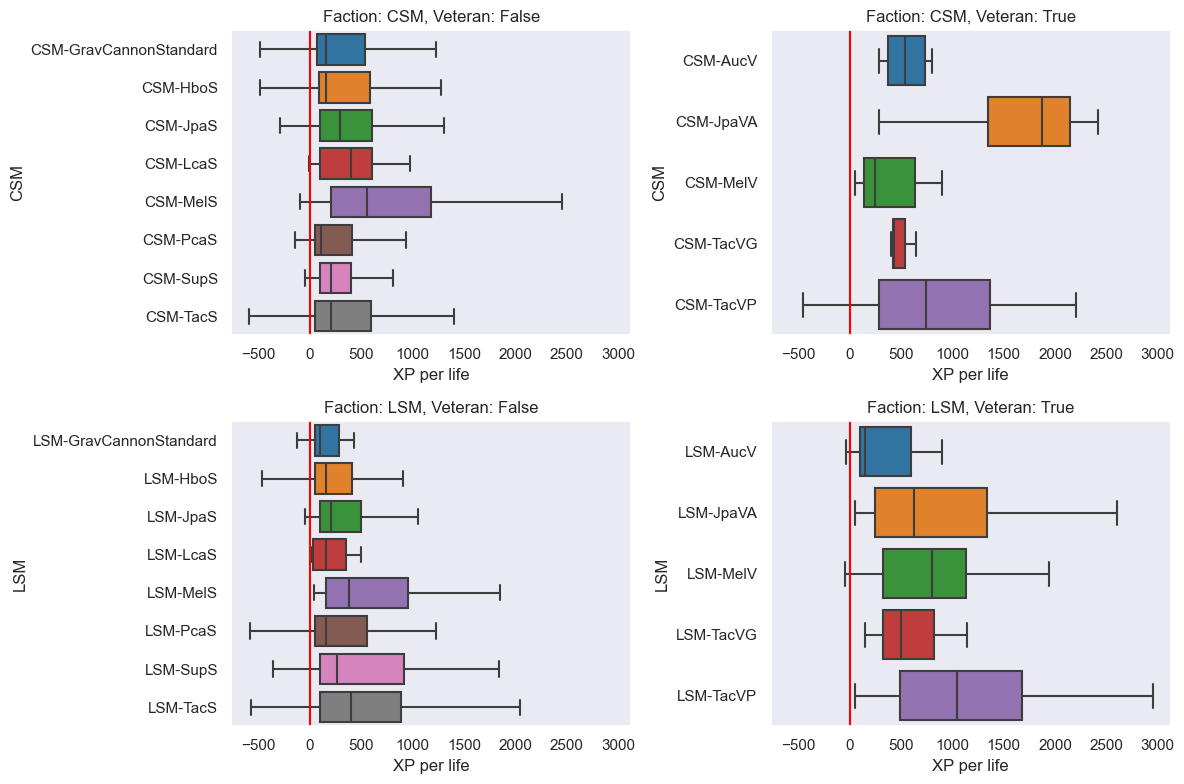

In [20]:
# Create a grid of subplots
fig, axes = plt.subplots(
    nrows=len(xp_per_pawn['faction'].unique()),
    ncols=len(xp_per_pawn['is_veteran'].unique()),
    figsize=(12, 8),
    sharex=share_x
)

# Grouping into subplots
for ((faction, veteran), subset), ax in zip(xp_per_pawn.groupby(['faction', 'is_veteran']), axes.flat):
    subset = subset.sort_values(by='loadout')  # Sort by 'loadout'
    sns.boxplot(x='xp_per_life', y='loadout', data=subset, ax=ax, orient='h', showfliers=show_outliers)

    # Set titles and axis labels
    ax.set_title(f'Faction: {faction}, Veteran: {veteran}')
    ax.set_xlabel('XP per life')
    ax.set_ylabel(faction)

    # Set x-axis ticks for each subplot
    ax.tick_params(axis='x', labelbottom=True)

    ax.axvline(x=0, color='red')


# Adjust layout
plt.tight_layout()
plt.show()

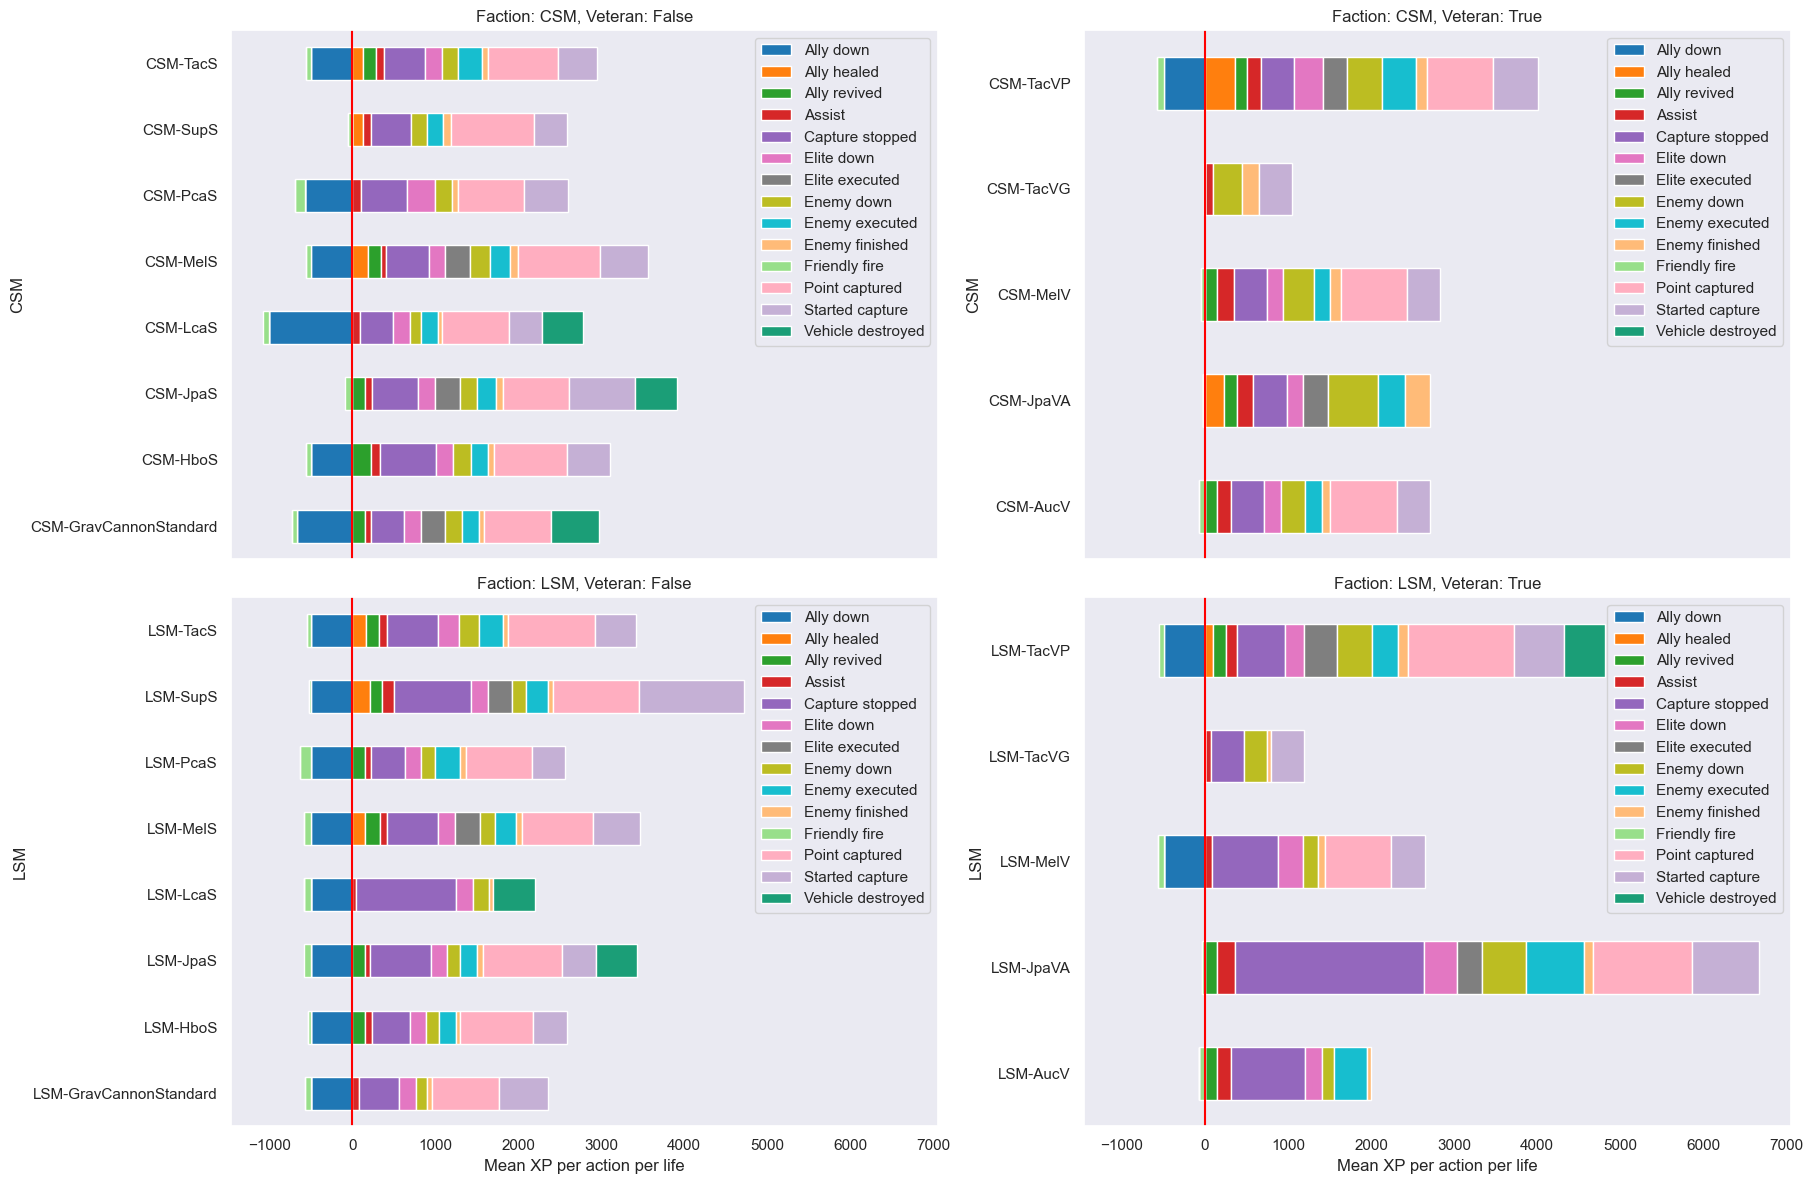

In [21]:
# Create a pivot table to reshape the data for plotting
pivot_xp_per_life_for_class_and_action = xp_per_life_for_class_and_action.reset_index()
pivot_xp_per_life_for_class_and_action = pivot_xp_per_life_for_class_and_action.pivot(index=['loadout', 'faction', 'is_veteran'], columns='action',
                                                                                      values='mean_xp_per_life')
pivot_xp_per_life_for_class_and_action = pivot_xp_per_life_for_class_and_action.reset_index().set_index("loadout")

# Create a grid of subplots
fig, axes = plt.subplots(
    nrows=len(xp_per_pawn['faction'].unique()),
    ncols=len(xp_per_pawn['is_veteran'].unique()),
    figsize=(24, 16),
    sharex=share_x
)

# Define a custom color palette
custom_colors = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728',  # Red
    '#9467bd',  # Purple
    '#e377c2',  # Pink
    '#7f7f7f',  # Gray
    '#bcbd22',  # Yellow-Green
    '#17becf',  # Cyan
    '#ffbb78',  # Light Orange
    '#98df8a',  # Light Green
    '#ffaec0',  # Light Pink
    '#c5b0d5',  # Light Purple
    '#1b9e77',  # Dark Green
]

# Grouping into subplots
for ((faction, veteran), subset), ax in zip(pivot_xp_per_life_for_class_and_action.groupby(['faction', 'is_veteran']), axes.flat):
    subset = subset.sort_values(by='loadout')  # Sort by 'loadout'
    subset = subset.drop(["faction", "is_veteran"], axis=1)

    # Create a rotated stacked barplot with the custom color palette
    subset.plot(kind='barh', stacked=True, figsize=(20, 12), color=custom_colors, ax=ax)

    # Set titles and axis labels
    ax.set_title(f'Faction: {faction}, Veteran: {veteran}')
    ax.set_xlabel('Mean XP per action per life')
    ax.set_ylabel(faction)

    # Set x-axis ticks for each subplot
    ax.tick_params(axis='x', labelbottom=True)
    ax.legend(bbox_to_anchor=(1, 1))

    ax.axvline(x=0, color='red')

# Adjust layout
plt.tight_layout()
plt.show()

## Analyzing KS ratios

In [22]:
kills_df = xp_df[xp_df["action"] == "Enemy down"]
kills_df.head()

,t,value,tps,tf,tl,tc,action,Type,match_ts,t-faction-class,t-is-veteran,tc_x,tc_y
0,CH_2147295112-2023-10-01T17-44-35.162716,100.0,PS_2147297338-2023-10-01T17-44-35.162716,LSM,MelS,X=74730.920 Y=18745.700 Z=-8847.520,Enemy down,XP,2023-10-01T17-44-35.162716,LSM-MelS,False,74730.920,18745.700
2,CH_2147291168-2023-10-01T17-44-35.162716,100.0,PS_2147294451-2023-10-01T17-44-35.162716,LSM,TacS,X=46243.809 Y=29396.023 Z=-4459.713,Enemy down,XP,2023-10-01T17-44-35.162716,LSM-TacS,False,46243.809,29396.023
4,CH_2147292772-2023-10-01T17-44-35.162716,100.0,PS_2147301349-2023-10-01T17-44-35.162716,CSM,TacS,X=46835.135 Y=29656.693 Z=-4459.710,Enemy down,XP,2023-10-01T17-44-35.162716,CSM-TacS,False,46835.135,29656.693
12,CH_2147288363-2023-10-01T17-44-35.162716,100.0,PS_2147294451-2023-10-01T17-44-35.162716,LSM,TacS,X=12258.622 Y=30361.950 Z=-1329.940,Enemy down,XP,2023-10-01T17-44-35.162716,LSM-TacS,False,12258.622,30361.950
16,CH_2147293255-2023-10-01T17-44-35.162716,100.0,PS_2147293422-2023-10-01T17-44-35.162716,LSM,TacS,X=55413.674 Y=24545.629 Z=-5686.410,Enemy down,XP,2023-10-01T17-44-35.162716,LSM-TacS,False,55413.674,24545.629


In [23]:
kills_per_pawn = kills_df.groupby(["t"]).agg(
    kill_count=('t', 'count'),
    loadout=('t-faction-class', 'first'),
    faction=('tf', 'first'),
    is_veteran=('t-is-veteran', 'first')
)
kills_per_pawn.head()

,kill_count,loadout,faction,is_veteran
t,,,,
CH_2145849199-2023-10-12T20-12-14.773177,3,CSM-HboS,CSM,False
CH_2145850096-2023-10-12T20-12-14.773177,1,CSM-GravCannonStandard,CSM,False
CH_2145853391-2023-10-12T20-12-14.773177,2,LSM-JpaVA,LSM,True
CH_2145854617-2023-10-12T20-12-14.773177,4,LSM-JpaVA,LSM,True
CH_2145856288-2023-10-12T20-12-14.773177,2,LSM-JpaS,LSM,False


In [24]:
kills_per_life_for_classes = kills_per_pawn.groupby("loadout").agg(
    mean_kills_per_life=('kill_count', 'mean'),
    std_kills_per_life=('kill_count', 'std')
)
kills_per_life_for_classes

,mean_kills_per_life,std_kills_per_life
loadout,,
CSM-AucV,3.000000,1.527525
CSM-GravCannonStandard,2.052632,1.177270
CSM-HboS,2.270270,1.674116
CSM-JpaS,2.114754,1.644165
CSM-JpaVA,6.000000,4.082483
CSM-LcaS,1.400000,0.699206
CSM-MelS,2.421053,2.297255
CSM-MelV,3.666667,3.444803
CSM-PcaS,2.028571,1.562158


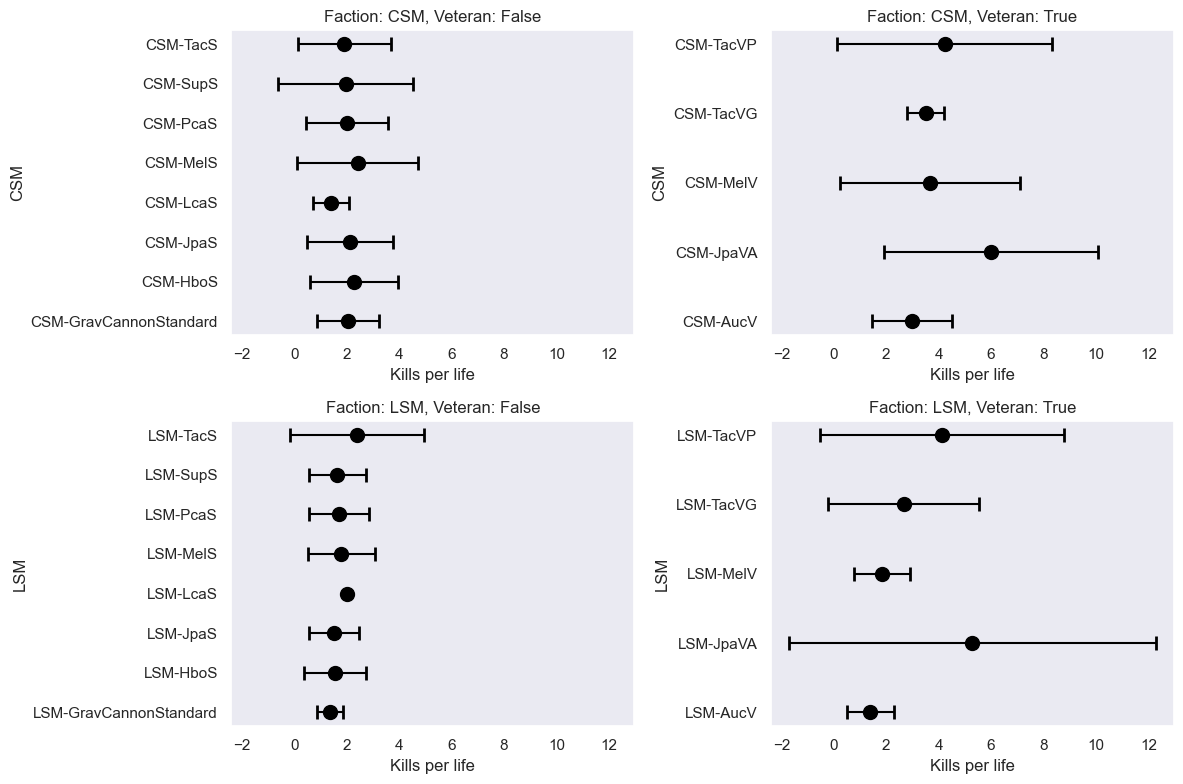

In [25]:
# Create a grid of subplots
fig, axes = plt.subplots(
    nrows=len(kills_per_pawn['faction'].unique()),
    ncols=len(kills_per_pawn['is_veteran'].unique()),
    figsize=(12, 8),
    sharex=share_x
)

# Grouping into subplots
for ((faction, veteran), subset), ax in zip(kills_per_pawn.groupby(['faction', 'is_veteran']), axes.flat):
    subset = subset.sort_values(by='loadout')  # Sort by 'loadout'

    grouped = subset.groupby('loadout')['kill_count']
    means = grouped.mean()
    stds = grouped.std()

    # Create a horizontal scatter plot for means
    ax.scatter(means, means.index, color='black', label='Mean', s=100, marker='o')  # Adjust the 's' parameter for size

    # Create vertical bars for standard deviation
    for i, (mean_val, std_val) in enumerate(zip(means, stds)):
        ax.errorbar(mean_val, i, xerr=std_val, fmt='|', color='black', capsize=5, capthick=2, label='Std Deviation')

    # Set titles and axis labels
    ax.set_title(f'Faction: {faction}, Veteran: {veteran}')
    ax.set_xlabel('Kills per life')
    ax.set_ylabel(faction)

    # Set x-axis ticks for each subplot
    ax.tick_params(axis='x', labelbottom=True)

# Adjust layout
plt.tight_layout()
plt.show()

## Analyzing class frequencies

In [26]:
spawn_df = pd.DataFrame([el for el in raw_data if el["Type"] == "Spawn"])

In [27]:
class_spawns = spawn_df["t-faction-class"].value_counts()

<Axes: title={'center': 'Classes spawn frequency'}, ylabel='t-faction-class'>

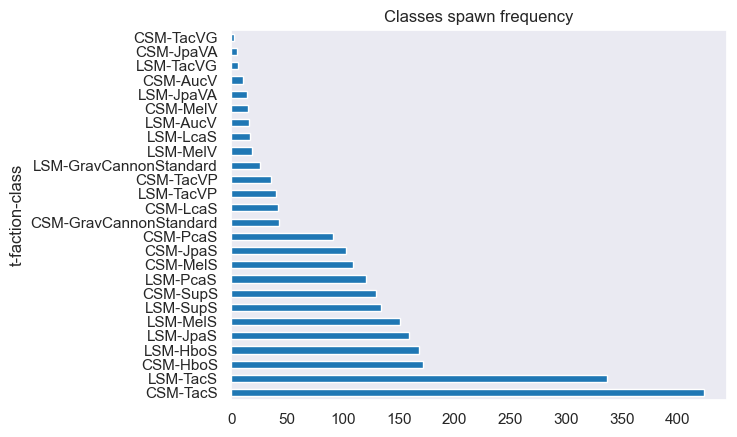

In [28]:
class_spawns.plot.barh(title="Classes spawn frequency")

## Heatmaps

### Damage dealers

In [29]:
x_points = list(damage_df["ic_x"])
y_points = list(damage_df["ic_y"])

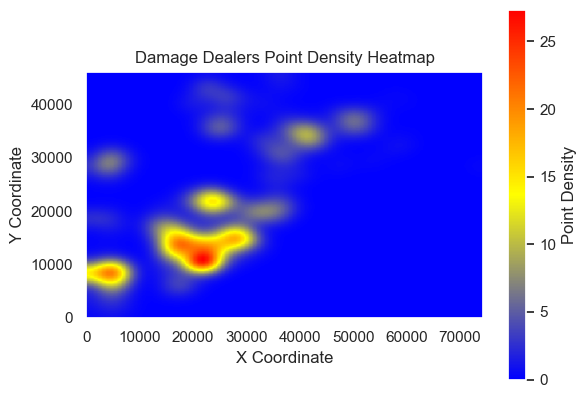

In [30]:
from matplotlib.colors import LinearSegmentedColormap

# Create a 2D histogram to represent point density
heatmap, xedges, yedges = np.histogram2d(x_points, y_points, bins=100)

# Smooth the heatmap using Gaussian convolution
from scipy.ndimage import gaussian_filter

heatmap = gaussian_filter(heatmap, sigma=3)

# Define a custom colormap (blue, yellow, red)
colors = [(0, 'blue'), (0.5, 'yellow'), (1, 'red')]
custom_cmap = LinearSegmentedColormap.from_list('custom', colors)

# Create the heatmap plot
plt.imshow(heatmap.T, origin='lower', extent=[0, xedges.max(), 0, yedges.max()], cmap=custom_cmap)
plt.colorbar(label='Point Density')  # Add a colorbar for reference
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Damage Dealers Point Density Heatmap')

plt.show()